In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [3]:

# 1) Load embeddings CSVs

TRAIN_EMB = "/content/train_embeddings.csv"
TEST_EMB  = "/content/test_embeddings.csv"

train_df = pd.read_csv(TRAIN_EMB)
test_df  = pd.read_csv(TEST_EMB)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
display(train_df.head())


/tmp/ipython-input-4196530404.py:6: DtypeWarning: Columns (445,446,447) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(TRAIN_EMB)


Train shape: (86938, 515)
Test shape: (10954, 515)


,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_505,feat_506,feat_507,feat_508,feat_509,feat_510,feat_511,race,gender,race_gender
0,0.843073,0.103579,0.224522,0.000000,0.778184,0.027723,0.454252,0.303014,0.029440,0.200618,...,0.150238,0.323468,0.784020,1.181147,0.422497,0.239257,0.723814,east asian,male,east asian_male
1,0.180621,1.292241,0.971825,0.132645,0.015272,0.305211,0.422381,0.379263,0.054428,0.007033,...,0.650830,2.343723,0.182173,0.085612,1.129795,0.638840,0.099425,indian,female,indian_female
2,0.012478,0.151712,0.666835,0.229115,0.108760,0.079838,0.191968,0.000000,0.269209,0.378046,...,0.322626,1.649574,0.019350,0.490857,0.762305,0.825264,0.454207,black,female,black_female
3,0.175503,0.309288,1.302044,0.065322,0.318755,0.151344,0.223482,0.075722,0.164445,0.174925,...,0.501732,0.948112,1.632882,0.479979,0.363495,0.169139,0.768003,indian,female,indian_female
4,0.066143,0.208480,1.062915,0.474760,0.000000,0.000000,0.041315,0.009158,0.053300,0.624211,...,0.697677,2.309969,0.987021,0.091093,0.343762,0.901343,0.149076,indian,female,indian_female


In [4]:
print("Total columns:", len(train_df.columns))
print("\nFirst 20 columns:")
print(train_df.columns[:20])

print("\nLast 10 columns:")
print(train_df.columns[-10:])


Total columns: 515

First 20 columns:
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19'],
      dtype='object')

Last 10 columns:
Index(['feat_505', 'feat_506', 'feat_507', 'feat_508', 'feat_509', 'feat_510',
       'feat_511', 'race', 'gender', 'race_gender'],
      dtype='object')


In [5]:
# checking for missing values
print("Missing gender in train:", train_df["gender"].isna().sum())
print("Missing gender in test:", test_df["gender"].isna().sum())


Missing gender in train: 1
Missing gender in test: 0


In [6]:
# drop nan
train_df = train_df.dropna(subset=["gender"]).copy()


In [7]:
# =========================
# 1) Feature + target setup
# =========================

FEATURE_COLS = [c for c in train_df.columns if c.startswith("feat_")]
TARGET = "gender"

print("Number of embedding features:", len(FEATURE_COLS))
print("Unique genders:", train_df[TARGET].unique())


Number of embedding features: 512
Unique genders: ['male' 'female']


In [8]:
# 2) Encode target


from sklearn.preprocessing import LabelEncoder

train_df[TARGET] = train_df[TARGET].astype(str).str.lower().str.strip()
test_df[TARGET]  = test_df[TARGET].astype(str).str.lower().str.strip()

enc = LabelEncoder()
y_train = enc.fit_transform(train_df[TARGET])
y_test  = enc.transform(test_df[TARGET])

X_train = train_df[FEATURE_COLS].values
X_test  = test_df[FEATURE_COLS].values

print("Encoded classes:", list(enc.classes_))


Encoded classes: ['female', 'male']


In [9]:
# Train models


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=800, class_weight="balanced"))
])

knn = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=25, weights="distance"))
])

models = {"LogReg": logreg, "KNN": knn}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)

    print("\n==============================")
    print("MODEL:", name)
    print("==============================")
    print("Accuracy:", round(accuracy_score(y_test, pred), 4))
    print(classification_report(y_test, pred, target_names=list(enc.classes_)))



MODEL: LogReg
Accuracy: 0.771
              precision    recall  f1-score   support

      female       0.75      0.76      0.76      5162
        male       0.79      0.78      0.78      5792

    accuracy                           0.77     10954
   macro avg       0.77      0.77      0.77     10954
weighted avg       0.77      0.77      0.77     10954


MODEL: KNN
Accuracy: 0.7507
              precision    recall  f1-score   support

      female       0.77      0.66      0.72      5162
        male       0.73      0.83      0.78      5792

    accuracy                           0.75     10954
   macro avg       0.75      0.75      0.75     10954
weighted avg       0.75      0.75      0.75     10954



### Subgroup accuracy (bias by race)

In this section, I evaluated how the model performs across different demographic groups rather than only reporting overall accuracy. The function groups the test data by a specified attribute, such as race, and calculates the classification accuracy within each subgroup. This allows me to identify whether certain groups experience systematically lower predictive performance. By comparing subgroup accuracies, I can quantify disparities and compute an accuracy gap between the highest and lowest performing groups, which serves as an indicator of potential outcome bias.

In [10]:
# Subgroup accuracy


def subgroup_accuracy(meta_df, y_true, y_pred, group_col):
    df = meta_df.copy()
    df["y_true"] = y_true
    df["y_pred"] = y_pred
    df["correct"] = (df["y_true"] == df["y_pred"]).astype(int)

    out = (
        df.groupby(group_col)["correct"]
        .mean()
        .reset_index(name="accuracy")
        .sort_values("accuracy")
    )
    return out

for name, clf in models.items():
    pred = clf.predict(X_test)

    print("\n======================================")
    print("BIAS ANALYSIS:", name)
    print("======================================")

    acc_race = subgroup_accuracy(test_df[["race"]], y_test, pred, "race")
    display(acc_race)

    print("Race accuracy gap:",
          round(acc_race["accuracy"].max() - acc_race["accuracy"].min(), 4))



BIAS ANALYSIS: LogReg


,race,accuracy
0,black,0.694730
1,east asian,0.770323
5,southeast asian,0.771731
3,latino_hispanic,0.772027
6,white,0.778417
2,indian,0.783641
4,middle eastern,0.839537


Race accuracy gap: 0.1448

BIAS ANALYSIS: KNN


,race,accuracy
0,black,0.667738
2,indian,0.736807
3,latino_hispanic,0.752311
5,southeast asian,0.756184
6,white,0.762110
1,east asian,0.766452
4,middle eastern,0.826303


Race accuracy gap: 0.1586


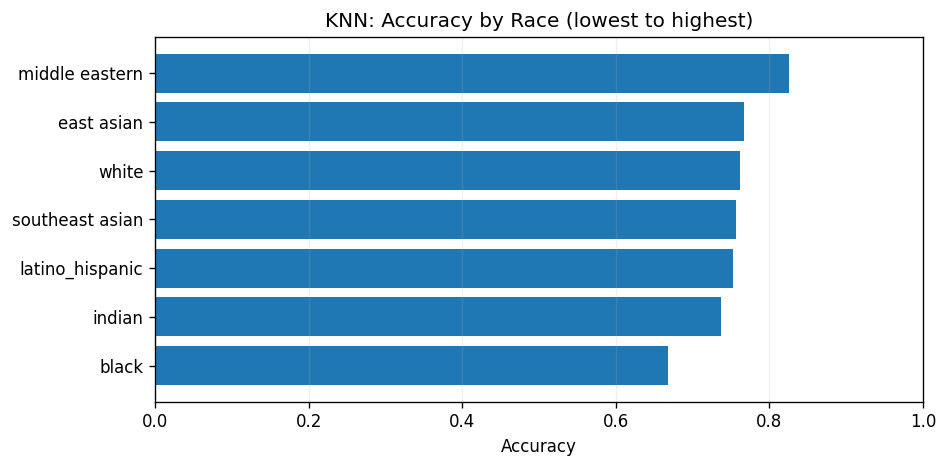

Race accuracy gap (max-min): 0.1586


In [11]:
import matplotlib.pyplot as plt

acc_plot = acc_race.sort_values("accuracy").copy()

plt.figure(figsize=(8,4), dpi=120)
plt.barh(acc_plot["race"].astype(str), acc_plot["accuracy"])
plt.title(f"{name}: Accuracy by Race (lowest to highest)")
plt.xlabel("Accuracy")
plt.xlim(0, 1)
plt.grid(axis="x", alpha=0.2)
plt.tight_layout()
plt.show()

print("Race accuracy gap (max-min):",
      round(acc_plot["accuracy"].max() - acc_plot["accuracy"].min(), 4))


### Checking for an Intersectional Bias

Here, I extend the subgroup analysis to an intersectional level by grouping individuals based on combined attributes, such as race and gender. Instead of examining each demographic factor independently, this approach captures how overlapping identities may experience different predictive outcomes. The goal is to detect whether specific subgroups, for example a particular race-gender combination, are disproportionately misclassified. This analysis is important because fairness issues often become more visible when demographic categories are evaluated jointly rather than in isolation.

In [12]:
for name, clf in models.items():
    pred = clf.predict(X_test)

    acc_inter = subgroup_accuracy(
        test_df[["race_gender"]],
        y_test,
        pred,
        "race_gender"
    )

    print("\nIntersectional accuracy -", name)
    display(acc_inter.head(15))

    print("Intersectional gap:",
          round(acc_inter["accuracy"].max() - acc_inter["accuracy"].min(), 4))



Intersectional accuracy - LogReg


,race_gender,accuracy
0,black_female,0.619551
3,east asian_male,0.725869
11,southeast asian_male,0.740136
4,indian_female,0.757536
6,latino_hispanic_female,0.759036
1,black_male,0.765957
13,white_male,0.775401
12,white_female,0.781931
7,latino_hispanic_male,0.785624
10,southeast asian_female,0.805882


Intersectional gap: 0.2255

Intersectional accuracy - KNN


,race_gender,accuracy
0,black_female,0.483487
4,indian_female,0.617300
6,latino_hispanic_female,0.679518
12,white_female,0.698858
10,southeast asian_female,0.717647
8,middle eastern_female,0.727273
2,east asian_female,0.752911
3,east asian_male,0.779923
11,southeast asian_male,0.791837
13,white_male,0.816399


Intersectional gap: 0.3911


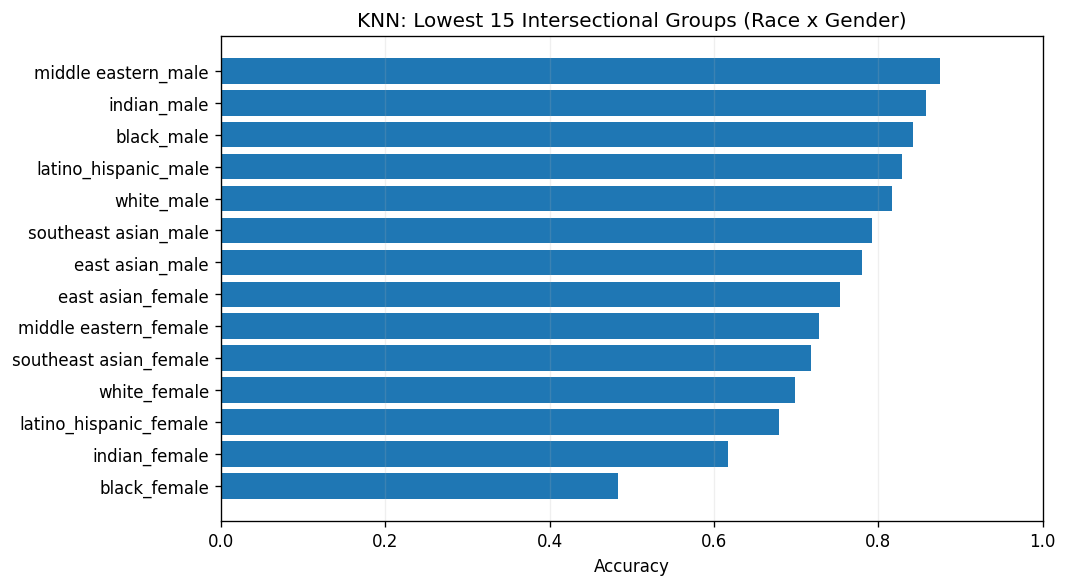

Intersectional accuracy gap (max-min): 0.3911


In [13]:
import matplotlib.pyplot as plt

inter_plot = acc_inter.sort_values("accuracy").head(15).copy()

plt.figure(figsize=(9,5), dpi=120)
plt.barh(inter_plot["race_gender"].astype(str), inter_plot["accuracy"])
plt.title(f"{name}: Lowest 15 Intersectional Groups (Race x Gender)")
plt.xlabel("Accuracy")
plt.xlim(0, 1)
plt.grid(axis="x", alpha=0.2)
plt.tight_layout()
plt.show()

print("Intersectional accuracy gap (max-min):",
      round(acc_inter["accuracy"].max() - acc_inter["accuracy"].min(), 4))


### Fairness Error Metrics Block


In this section, I moved beyond simple accuracy and examined error-based fairness metrics across demographic groups. Specifically, I computed the true positive rate, false positive rate, positive predictive value, and selection rate for each race. These metrics provide a more granular understanding of how the model treats different groups. For instance, differences in true positive rates relate to equal opportunity, while differences in false positive rates highlight unequal error burdens. By calculating the maximum minus minimum gap for each metric, I quantify the extent of disparity in the model’s behavior.

In [14]:
from sklearn.metrics import confusion_matrix
import numpy as np

def fairness_rates_by_race(meta_df, y_true, y_pred, pos_class=1):
    df = meta_df.copy()
    df["y_true"] = y_true
    df["y_pred"] = y_pred

    rows = []

    for race, sub in df.groupby("race"):
        y_t = (sub["y_true"] == pos_class).astype(int)
        y_p = (sub["y_pred"] == pos_class).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_t, y_p, labels=[0,1]).ravel()

        tpr = tp/(tp+fn) if (tp+fn) else np.nan
        fpr = fp/(fp+tn) if (fp+tn) else np.nan
        ppv = tp/(tp+fp) if (tp+fp) else np.nan
        sel = (y_p == 1).mean()

        rows.append({
            "race": race,
            "TPR": tpr,
            "FPR": fpr,
            "PPV": ppv,
            "SelectionRate": sel
        })

    return pd.DataFrame(rows)

if len(enc.classes_) == 2:
    pos_class = int(np.where(enc.classes_ == "male")[0][0])

    for name, clf in models.items():
        pred = clf.predict(X_test)

        rates = fairness_rates_by_race(
            test_df[["race"]],
            y_test,
            pred,
            pos_class=pos_class
        )

        print("\nFairness rates by race -", name)
        display(rates)

        print("TPR gap:", round(rates["TPR"].max() - rates["TPR"].min(), 4))
        print("FPR gap:", round(rates["FPR"].max() - rates["FPR"].min(), 4))
        print("PPV gap:", round(rates["PPV"].max() - rates["PPV"].min(), 4))
        print("Selection rate gap:",
              round(rates["SelectionRate"].max() - rates["SelectionRate"].min(), 4))



Fairness rates by race - LogReg


,race,TPR,FPR,PPV,SelectionRate
0,black,0.765957,0.380449,0.680000,0.578406
1,east asian,0.725869,0.184994,0.797737,0.456129
2,indian,0.810093,0.242464,0.767296,0.524406
3,latino_hispanic,0.785624,0.240964,0.756987,0.507086
4,middle eastern,0.845018,0.171717,0.909934,0.624483
5,southeast asian,0.740136,0.194118,0.804734,0.477739
6,white,0.775401,0.218069,0.805556,0.517986


TPR gap: 0.1191
FPR gap: 0.2087
PPV gap: 0.2299
Selection rate gap: 0.1684

Fairness rates by race - KNN


,race,TPR,FPR,PPV,SelectionRate
0,black,0.842303,0.516513,0.632519,0.683805
1,east asian,0.779923,0.247089,0.760351,0.514194
2,indian,0.857902,0.382700,0.688699,0.618734
3,latino_hispanic,0.828499,0.320482,0.711809,0.568700
4,middle eastern,0.874539,0.272727,0.868132,0.677419
5,southeast asian,0.791837,0.282353,0.751938,0.546996
6,white,0.816399,0.301142,0.759536,0.578417


TPR gap: 0.0946
FPR gap: 0.2694
PPV gap: 0.2356
Selection rate gap: 0.1696


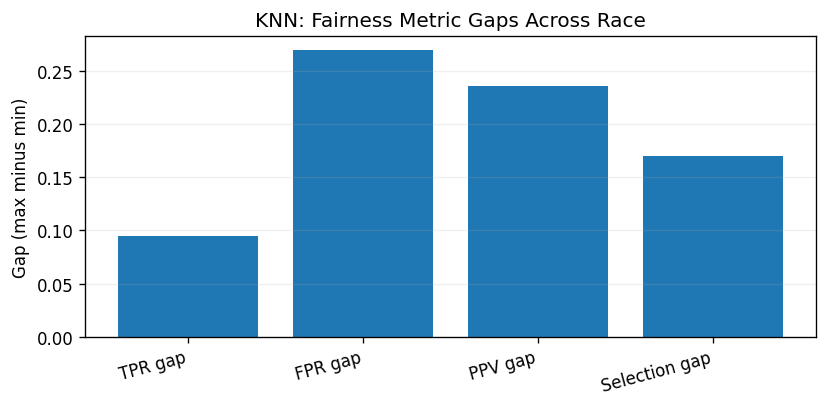

{'TPR gap': 0.0946, 'FPR gap': 0.2694, 'PPV gap': 0.2356, 'Selection gap': 0.1696}


In [15]:
import matplotlib.pyplot as plt

gaps = {
    "TPR gap": rates["TPR"].max() - rates["TPR"].min(),
    "FPR gap": rates["FPR"].max() - rates["FPR"].min(),
    "PPV gap": rates["PPV"].max() - rates["PPV"].min(),
    "Selection gap": rates["SelectionRate"].max() - rates["SelectionRate"].min()
}

plt.figure(figsize=(7,3.5), dpi=120)
plt.bar(list(gaps.keys()), list(gaps.values()))
plt.title(f"{name}: Fairness Metric Gaps Across Race")
plt.ylabel("Gap (max minus min)")
plt.grid(axis="y", alpha=0.2)
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

print({k: round(v, 4) for k, v in gaps.items()})
